In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py 
import yaml
import datetime
import os
import h5py
from tqdm import tqdm
import util
%matplotlib ipympl
import matplotlib
colormap = plt.cm.plasma_r
normalize = matplotlib.colors.Normalize(vmin=0, vmax=60)
drift_speed=0.11

from importlib import reload

reload(util)

from util import index_to_chip_channel, chip_channel_to_index
            
vref = (255/256)*2460 # mV
lsb = vref/1024 # mV
lsb_ke = lsb / 4. # mV/ke-

def mv(d):
    return vref/2 + lsb*(d-512)
    

In [29]:
x_shift=np.max(pixel_x)
y_shift = np.max(pixel_y)

In [2]:
# CONSTRUCT Geometry Information for Charge
pixel_x, pixel_y = util.construct_geometry()
peds = util.construct_pedestal('/data/v3/5x5/cold_Apr2025/cold_ped/cold-pedestal-255-packets-cooldown-2025_04_10_12_47_PDT.h5')

/home/stephen/.local/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


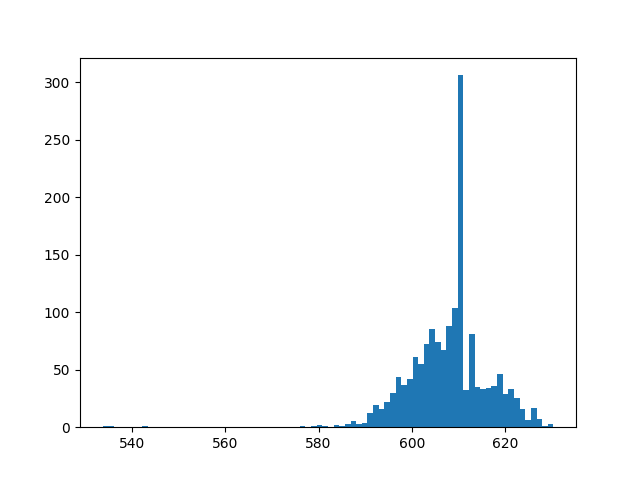

In [3]:
fig=plt.figure()
plt.hist(mv(peds[peds>0]), bins=80);

In [4]:
sync_packet_type = 6

def packets_to_full_timestamp(packets):
    syncs = np.where(packets['packet_type']==6)[0]
    correction = np.zeros(len(packets))
    for i in range(1, len(syncs)):
        correction[ syncs[i] :   ] += 1e7
    return packets['timestamp'] + correction
        
def find_events(packets, min_hits=10):
    timestamps=[]
    used_mask = np.zeros(len(packets)).astype(int)
    
    times = packets['timestamp'].astype(int)
    for ts in set(times):
        mask = np.logical_and(np.absolute( times - ts) < 1000, np.logical_not(used_mask))
        if np.sum(mask) >= min_hits:
            un = chip_channel_to_index(packets[mask]['chip_id'], packets[mask]['channel_id'])
            if len(set(un))<10: continue
            #un_chips = set((un//100)*100)
            un_chips = chip_channel_to_index(packets[mask]['chip_id'], packets[mask]['chip_id'])
            if len(set(un_chips))<2: continue
            used_mask = np.logical_or(used_mask, mask)
            timestamps.append(ts)
            
    return timestamps

def get_hit_xyzqt(packets, ts):
    mask = np.absolute(packets['timestamp'] - ts) < 1000
    d=packets[mask]
    un = chip_channel_to_index(d['chip_id'].astype(int), d['channel_id'].astype(int))
    x, y = pixel_x[un], pixel_y[un]
    z = (d['timestamp'].astype(int) - np.min(d['timestamp'].astype(int)))*drift_speed
    q = (mv(d['dataword'].astype(int))-mv(peds[un]))*lsb_ke
    t = d['timestamp'].astype(int) - np.min(d['timestamp'].astype(int))
    return x, y, z, q, t


from sklearn.decomposition import PCA

def find_mips_crossing(packets):
    timestamps = find_events(packets)
    
    mip_timestamps = []
    
    for ts in set(timestamps):
        
        x, y, z, q, t = get_hit_xyzqt(packets, ts)
        if len(x) < 3: continue
        
        #perform PCA to find straight tracks
        
        X=np.array( [x, y, z] ).transpose()
        
        pca = PCA(n_components=3)
        pca.fit(X)
        
        if not np.max(pca.explained_variance_ratio_) > 0.96: continue
            
        #check that max z - min z distance is >9 cm
        
        if not (np.max(z) - np.min(z)) > 90: continue
        mip_timestamps.append(ts)
        
    return mip_timestamps

def find_mips_burst_mode(packets):
    timestamps = find_events(packets)
    
    mip_timestamps = []
    
    for ts in set(timestamps):
        
        x, y, z, q, t = get_hit_xyzqt(packets, ts)
        
        if len(x) < 3: continue
        
        #perform PCA to find straight tracks
        
        X=np.array( [x, y, z] ).transpose()
        
        pca = PCA(n_components=3)
        pca.fit(X)
        
        if not np.max(pca.explained_variance_ratio_) > 0.9: continue
            
        mip_timestamps.append(ts)
        
    return mip_timestamps
    

In [5]:
def aggregate_xyzqt(data, ts):
    x, y, z, q, t = [], [], [], [], []
    for ttt in ts:
        _x, _y, _z, _q, _t = get_hit_xyzqt(data, ttt)
        
        x+=list(_x)
        y+=list(_y)
        z+=list(_z)
        q+=list(_q)
        t+=list(_t)
        
    return x, y, z, q, t
        

In [22]:
file='/data/v3/5x5/cold_Apr2025/cosmics_5kv/packet-cooldown-2025_04_10_13_21_39_PDT.h5'
f=h5py.File(file)
packets=f['packets']
data=packets[packets['packet_type']==1]
ts=find_events(data, min_hits=20)
ts_mips = find_mips_burst_mode(data)

In [20]:
#Find nonlinear events
cool_ts=[]

for tts in ts:
    x, y, z, q, t = get_hit_xyzqt(data, tts)
    
    X=np.array( [x, y, z] ).transpose()
        
    pca = PCA(n_components=3)
    pca.fit(X)
        
    #if not (np.max(pca.explained_variance_ratio_) < 0.99999 ): continue
        
    cool_ts.append(tts)

used=set()

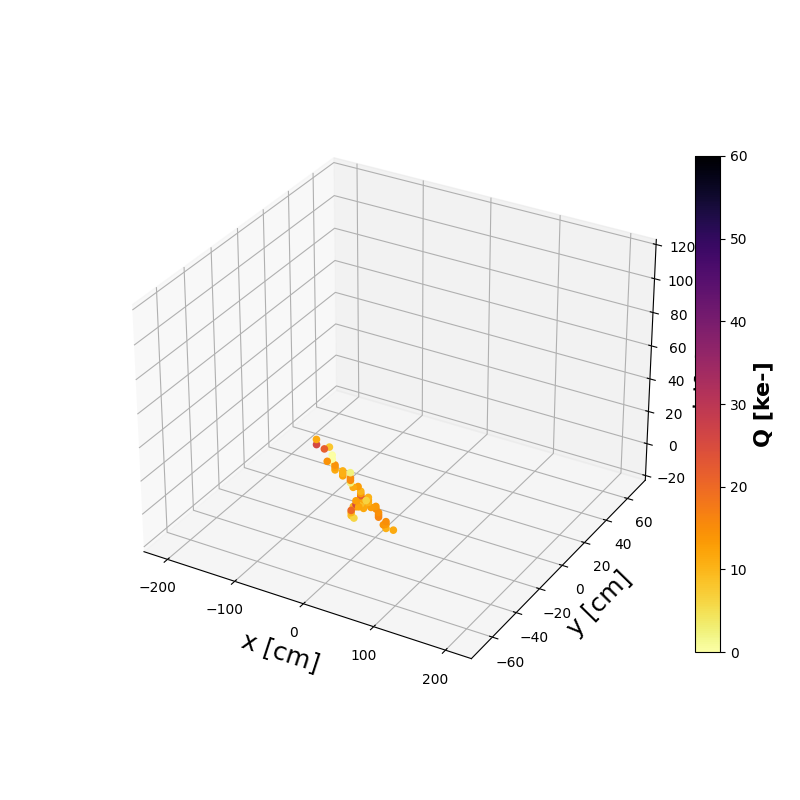

In [94]:
# run me multiple times to visualize new events!

for tts in ts:
    if tts in used: continue
    x, y, z, q, t = get_hit_xyzqt(data, tts)
    if x.shape[0]<40: continue
    used.add(tts)
    break

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection='3d')
sc=ax.scatter( x, y, z, norm=normalize,c=q, cmap='inferno_r', alpha=1)
cb = plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cb.set_label(label='Q [ke-]',weight='bold', fontsize=16)
ax.set_xlabel('x [cm]', fontsize=18)
ax.set_ylabel('y [cm]', fontsize=18)
ax.set_zlabel('drift [mm]', fontsize=18)
ax.set_xlim(-x_shift, x_shift)
ax.set_ylim(-y_shift, y_shift)
ax.set_zlim(-20, 120)
plt.show()
ax.view_init(25,20)



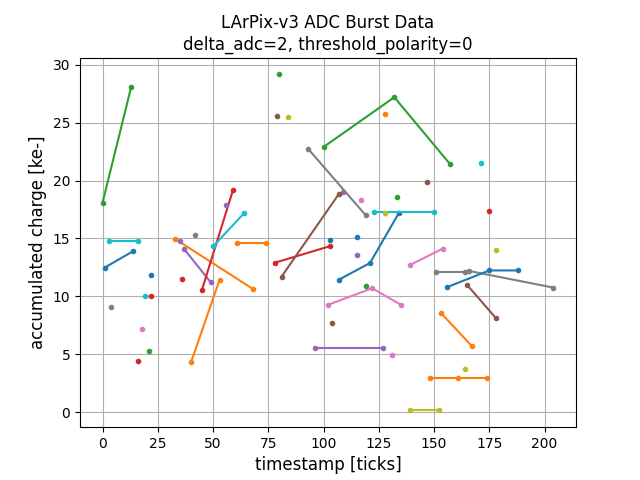

In [10]:
#Look at ADC Burst mode data

x=np.array(x)
y=np.array(y)
t=np.array(t)
q=np.array(q)

used=set()

fig = plt.figure()
ax=fig.add_subplot()

for xy in list(zip(x, y)):
    if xy in used: continue
    used.add(xy)
    
    mx = x==xy[0]
    my = y==xy[1]
    mq = q>0
    m= mx & my & mq
    _q=q[m]
    _t=t[m]
    
    ax.plot(_t, _q, marker='.')
    
ax.set_title('LArPix-v3 ADC Burst Data\ndelta_adc=2, threshold_polarity=0')
ax.set_xlabel('timestamp [ticks]', fontsize=12)
ax.set_ylabel('accumulated charge [ke-]', fontsize=12)
ax.grid()

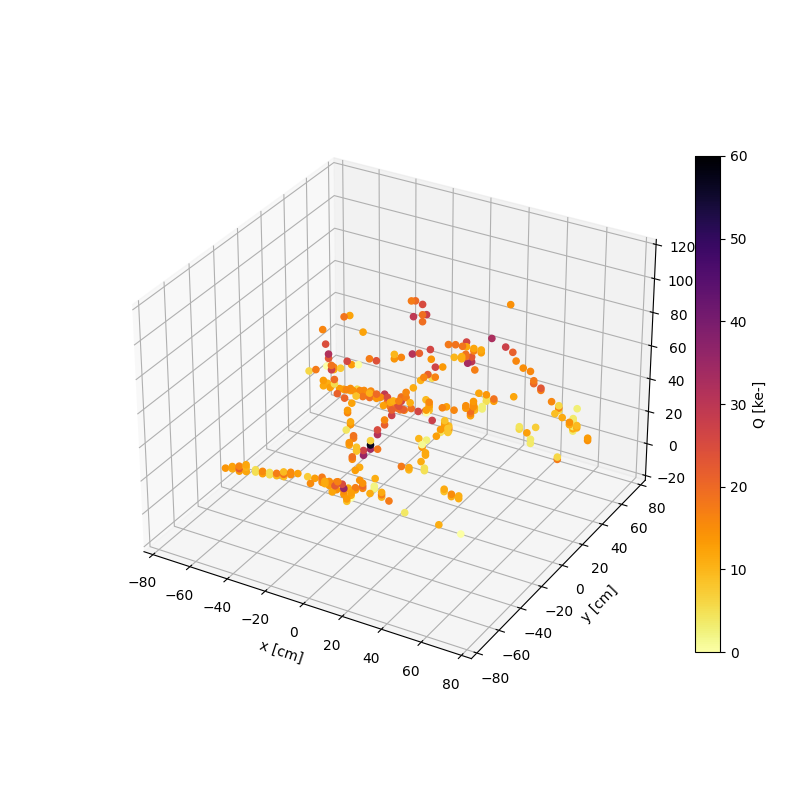

In [11]:
x, y, z, q, t = [], [],[],[],[]
for tts in [cool_ts[0], cool_ts[4],cool_ts[5], cool_ts[6], cool_ts[8], cool_ts[11]] :
    _x, _y, _z, _q, _t = get_hit_xyzqt(data, tts)
    x+=list(_x)
    y+=list(_y)
    z+=list(_z)
    t+=list(_t)
    q+=list(_q)

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(projection='3d')
sc=ax.scatter( x, y, z, norm=normalize,c=q, cmap='inferno_r', alpha=1)
plt.colorbar(sc, ax=ax, fraction=0.04, pad=0.02, label='Q [ke-]')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('drift [mm]')
#ax.set_xlim(-x_shift, x_shift)
#ax.set_ylim(-y_shift, y_shift)
ax.set_zlim(-20, 120)
plt.show()


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
def rotate_3d_plot(fig, ax, save_path="rotation.gif", elev=30, frames=200, interval=100):

    # Animation function
    def update(frame):
        elev = 15 + 15 * np.sin(4 * np.pi * frame / frames)  # oscillating elevation
        ax.view_init(elev=elev, azim=frame * (360 / frames))
        return fig,

    # Create animation
    ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=False)

    # Save to GIF
    ani.save(save_path, writer=PillowWriter(fps=120))
    plt.close()
    print(f"Saved rotation GIF to: {save_path}")

In [39]:
rotate_3d_plot(fig, ax, save_path='fun_event_8_burst.gif')

Saved rotation GIF to: fun_event_8_burst.gif
